Computing transition probabilities:   0%|          | 0/94 [00:00<?, ?it/s]

C:\Users\d.mentock\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


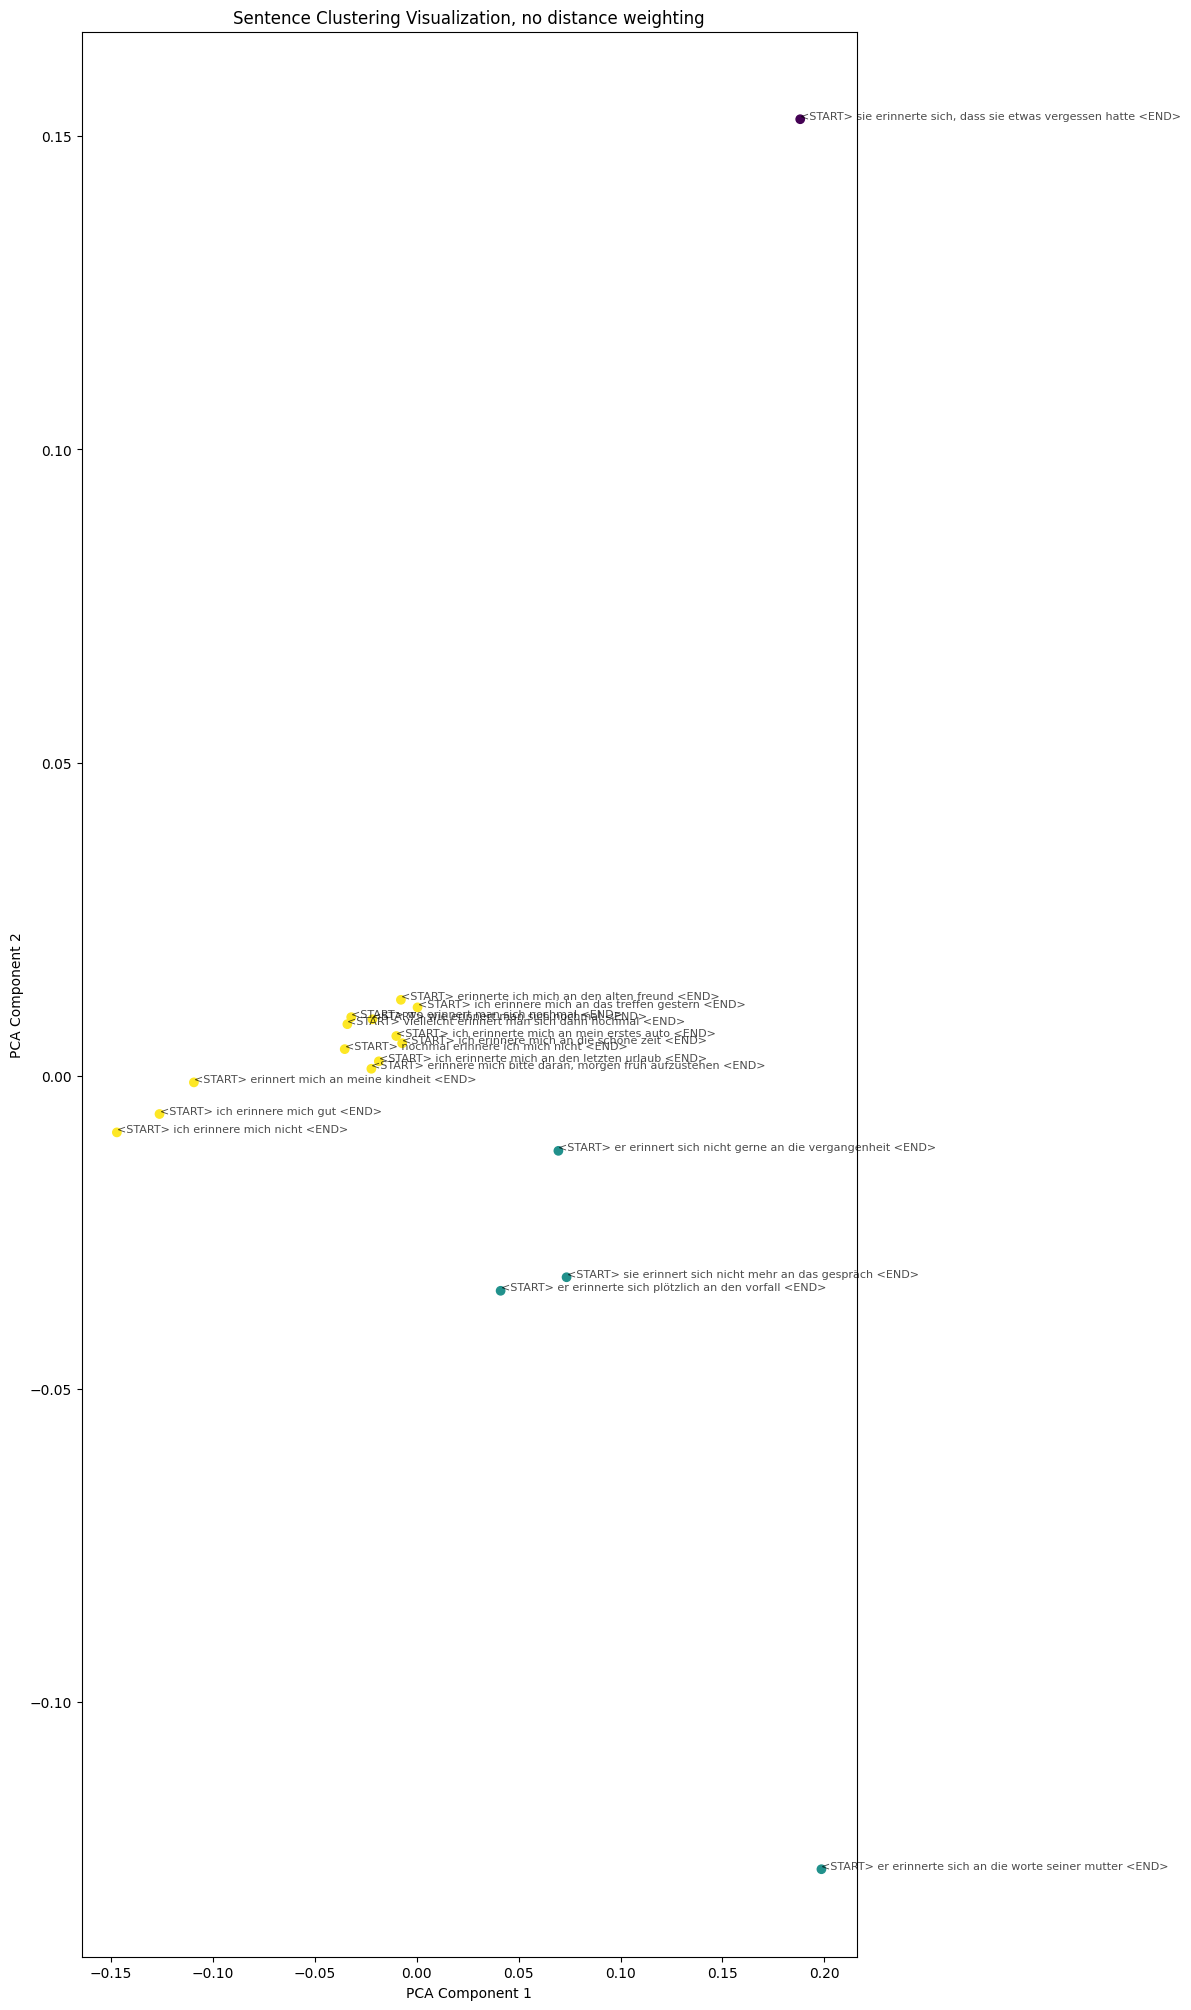

C:\Users\d.mentock\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


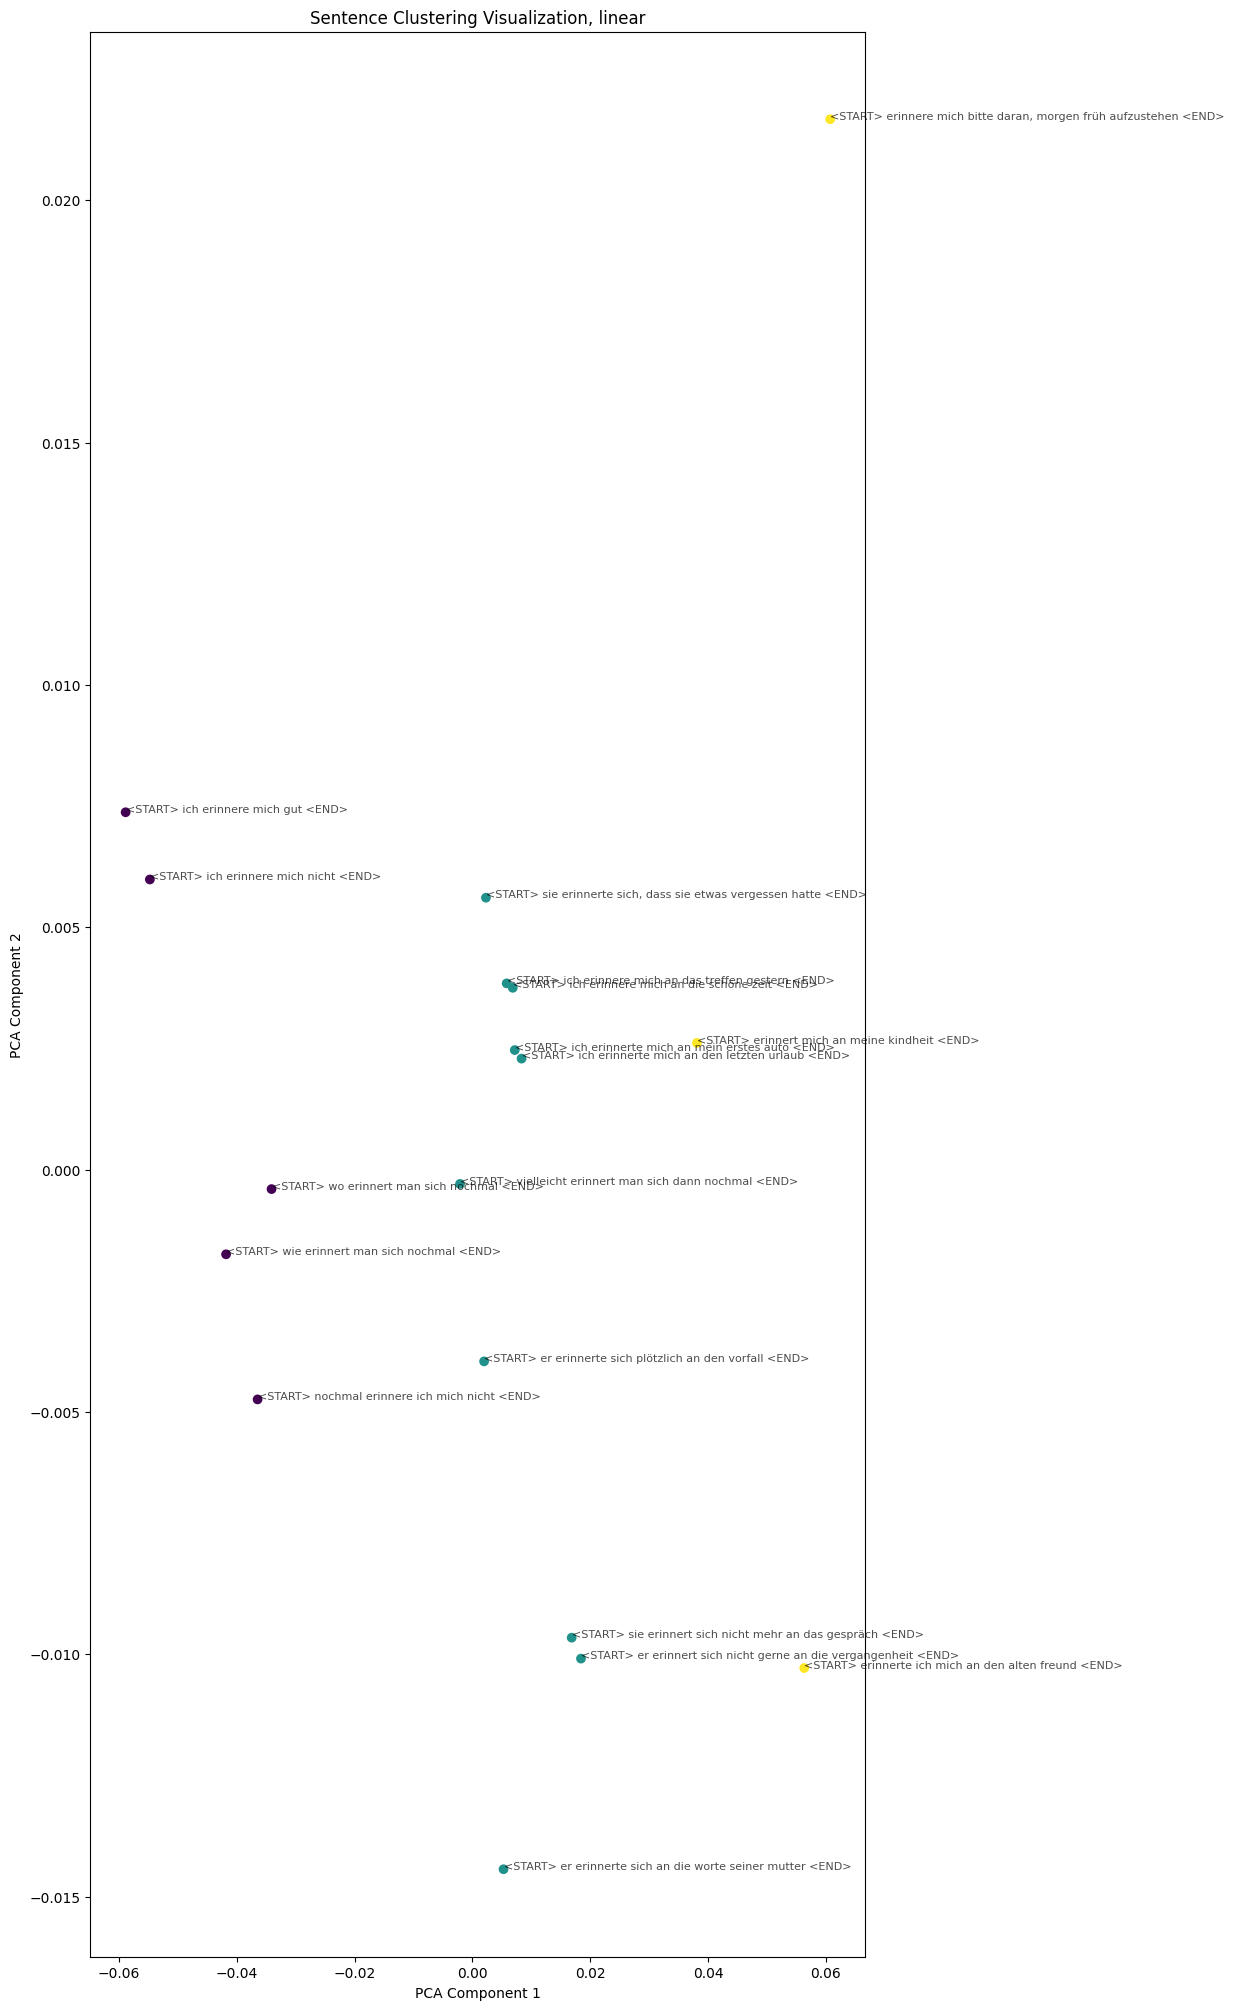

C:\Users\d.mentock\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


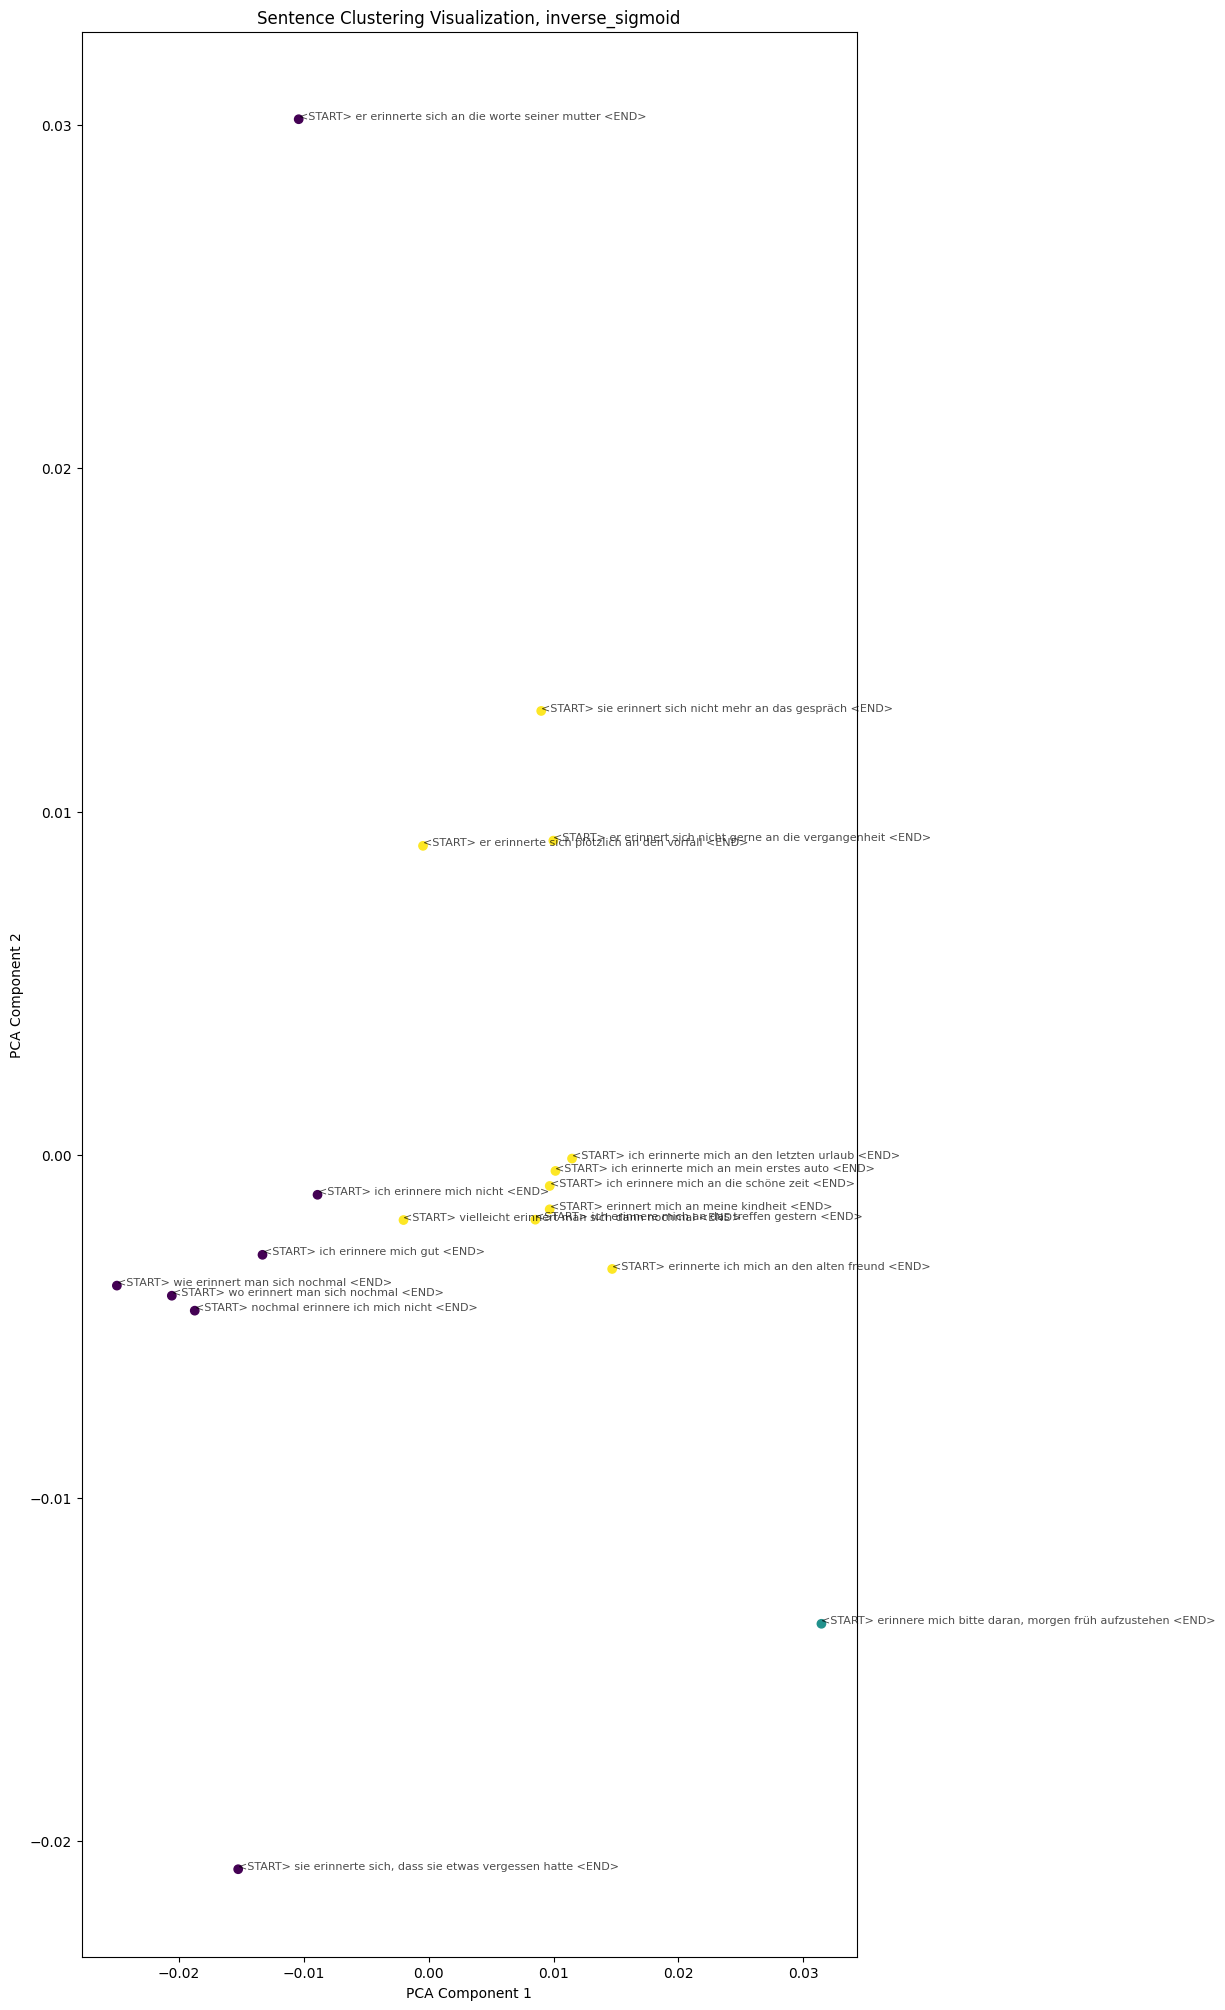

In [6]:
import networkx as nx
from node2vec import Node2Vec
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import defaultdict, deque


class Node:
    def __init__(self, word, id):
        self.word = word
        self.id = id
        self.count = 0
        self.children = {}


class PatternExtractor:
    def __init__(self):
        self.preceding_tree = Node('<ROOT>', 0)
        self.following_tree = Node('<ROOT>', 1)
        self.node_counter = 2
        self.word_to_ids = defaultdict(list)
        self.id_to_node = {0: self.preceding_tree, 1: self.following_tree}
        self.child_to_parents = defaultdict(list)
        self.node_embeddings = {}  # Store embeddings for each node
        self.graph = nx.DiGraph()  # Initialize a directed graph

    def add_start_end_flags_lower(self, sentences):
        return [f"<START> {sentence.lower()} <END>" for sentence in sentences]

    def get_or_create_node(self, current_tree, word, parent_id=None):
        if word not in current_tree.children:
            new_node = Node(word, self.node_counter)
            current_tree.children[word] = new_node
            self.word_to_ids[word].append(self.node_counter)
            self.id_to_node[self.node_counter] = new_node
            if parent_id is not None:
                self.child_to_parents[self.node_counter].append(parent_id)
                # Add edge from parent to child in the graph
                self.graph.add_edge(parent_id, self.node_counter)
            self.node_counter += 1
        else:
            child_id = current_tree.children[word].id
            if parent_id is not None:
                self.child_to_parents[child_id].append(parent_id)
                # Add edge from parent to child in the graph
                self.graph.add_edge(parent_id, child_id)
        return current_tree.children[word]

    def add_to_tree(self, words, direction, count=1):
        current_tree = self.preceding_tree if direction == 'preceding' else self.following_tree
        if direction == 'preceding':
            word_range = range(len(words) - 1, -1, -1)
        else:
            word_range = range(len(words))

        parent_id = current_tree.id

        for i in word_range:
            current_word = words[i]
            current_tree = self.get_or_create_node(current_tree, current_word, parent_id)
            current_tree.count += count
            parent_id = current_tree.id

    def create_tree_mask_as_root(self, sentences_dict):
        for morphology, sentences in sentences_dict.items():
            sentences_with_flags = self.add_start_end_flags_lower(sentences)

            for sentence in sentences_with_flags:
                words = sentence.lower().split()
                key_word_index = words.index(morphology.lower())
                words_before = words[:key_word_index]
                words_after = words[key_word_index + 1:]

                self.add_to_tree(words_before, 'preceding')
                self.add_to_tree(words_after, 'following')

    def build_graph(self, sentences_dict):
        self.create_tree_mask_as_root(sentences_dict)
        # We already created the graph edges in `get_or_create_node`, so nothing additional needed here

    def generate_node2vec_embeddings(self, embedding_size=100, walk_length=10, num_walks=50, p=1, q=1):
        # Initialize Node2Vec model from the graph
        node2vec = Node2Vec(self.graph, dimensions=embedding_size, walk_length=walk_length, num_walks=num_walks, p=p, q=q, workers=4)
        model = node2vec.fit(window=10, min_count=1, batch_words=4)

        # Store the learned embeddings in node_embeddings
        for node_id in self.graph.nodes:
            self.node_embeddings[node_id] = model.wv[str(node_id)]  # Use string key because Node2Vec treats nodes as strings

    def compute_weighted_sentence_embedding(self, sentence_path, weighting_scheme=None):
        weighted_embedding = np.zeros(len(self.node_embeddings[0]))  # Assuming all embeddings have the same size
        for i, node_id in enumerate(sentence_path):
            if weighting_scheme == 'linear':
                distance_from_root = i + 1
                weight = 1 / distance_from_root
            elif weighting_scheme == 'inverse_sigmoid':
                distance_from_root = i + 1
                steepness = 0.2
                weight = 1 - (1 / (1 + np.exp(-steepness * distance_from_root)))
            else:
                weight = 1
            weighted_embedding += weight * self.node_embeddings[node_id]
        return weighted_embedding / len(sentence_path)

    def get_sentence_embedding(self, sentence, morphology, weighting_scheme=None):
        """
        Given a sentence, return its corresponding embedding.
        """
        words = sentence.lower().split()
        node_path = deque([0])
        key_word_index = words.index(morphology.lower())
        words_before = words[:key_word_index]
        words_after = words[key_word_index + 1:]

        current_node = self.preceding_tree
        for i in range(len(words_before) - 1, -1, -1):
            word = words_before[i]
            if word in current_node.children:
                current_node = current_node.children[word]
                node_path.appendleft(current_node.id)
            else:
                raise

        current_node = self.following_tree
        for word in words_after:
            if word in current_node.children:
                current_node = current_node.children[word]
                node_path.append(current_node.id)
            else:
                raise
        return self.compute_weighted_sentence_embedding(node_path, weighting_scheme=weighting_scheme)

    def get_all_sentence_embeddings(self, sentences_dict, weighting_scheme=None):
        """
        Generate embeddings for all sentences in the dataset.
        """
        sentence_embeddings = []
        sentence_list = []
        for morphology, sentences in sentences_dict.items():
            sentences_with_flags = self.add_start_end_flags_lower(sentences)
            for sentence in sentences_with_flags:
                embedding = self.get_sentence_embedding(sentence, morphology, weighting_scheme=weighting_scheme)
                sentence_embeddings.append(embedding)
                sentence_list.append(sentence)
        return np.array(sentence_embeddings), sentence_list

    def cluster_sentences(self, embeddings, n_clusters=3):
        """
        Apply K-Means clustering to sentence embeddings.
        """
        kmeans = KMeans(n_clusters=n_clusters)
        clusters = kmeans.fit_predict(embeddings)
        return clusters

    def reduce_dimensionality(self, embeddings, n_components=2):
        """
        Reduce dimensionality of embeddings for visualization.
        """
        pca = PCA(n_components=n_components)
        reduced_embeddings = pca.fit_transform(embeddings)
        return reduced_embeddings

    def visualize_clusters(self, reduced_embeddings, clusters, sentence_list, title_appendix=None):
        """
        Visualize clusters using a 2D plot.
        """
        plt.figure(figsize=(10, 25))
        scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis')

        # Annotate sentences for better interpretability
        for i, sentence in enumerate(sentence_list):
            plt.annotate(sentence, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=8, alpha=0.7)

        plt.title(f"Sentence Clustering Visualization{', '+title_appendix if title_appendix else ''}")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.show()


# Create a PatternExtractor instance
extractor = PatternExtractor()
sentences_dict = {
    'erinnere': [
        'Ich erinnere mich gut',
        'ich erinnere mich nicht',
        'nochmal erinnere ich mich nicht',
        'ich erinnere mich an das Treffen gestern',
        'erinnere mich bitte daran, morgen früh aufzustehen',
        'ich erinnere mich an die schöne Zeit'
    ],
    'erinnert': [
        'wie erinnert man sich nochmal',
        'wo erinnert man sich nochmal',
        'vielleicht erinnert man sich dann nochmal',
        'erinnert mich an meine Kindheit',
        'sie erinnert sich nicht mehr an das Gespräch',
        'er erinnert sich nicht gerne an die Vergangenheit'
    ],
    'erinnerte': [
        'er erinnerte sich plötzlich an den Vorfall',
        'ich erinnerte mich an mein erstes Auto',
        'sie erinnerte sich, dass sie etwas vergessen hatte',
        'erinnerte ich mich an den alten Freund',
        'er erinnerte sich an die Worte seiner Mutter',
        'ich erinnerte mich an den letzten Urlaub'
    ]
}

# sentences_dict = {
#     'erinnere': [
#         'Ich erinnere mich gut',
#         'ich erinnere mich nicht',
#         'nochmal erinnere ich mich nicht'
#     ],
#     'erinnert': [
#         'wie erinnert man sich nochmal',
#         'wo erinnert man sich nochmal',
#         'vielleicht erinnert man sich dann nochmal'
#     ]
# }

# Step 1: Build the graph from the sentences
extractor.build_graph(sentences_dict)

# Step 2: Generate node embeddings using Node2Vec
extractor.generate_node2vec_embeddings(embedding_size=100)

# Step 3: Generate embeddings for all sentences and visualize the clustering
for weighting_scheme in ['no distance weighting', 'linear', 'inverse_sigmoid']:
    sentence_embeddings, sentence_list = extractor.get_all_sentence_embeddings(sentences_dict, weighting_scheme=weighting_scheme)
    n_clusters = 3  # You can adjust this based on the number of clusters you want
    clusters = extractor.cluster_sentences(sentence_embeddings, n_clusters=n_clusters)
    reduced_embeddings = extractor.reduce_dimensionality(sentence_embeddings)
    extractor.visualize_clusters(reduced_embeddings, clusters, sentence_list, title_appendix=weighting_scheme)
